Previsão de crescimento da Indústria de Transformação

Preparação dos Dados

In [84]:
#Importanto Bibliotecas
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import datetime
import glob
import re
from functools import reduce
from datetime import datetime
import locale
import pingouin as pg
pd.set_option('display.max_columns', None)

In [85]:
locale.setlocale(locale.LC_ALL, 'pt_pt.UTF-8')

'pt_pt.UTF-8'

In [86]:
# Listando as bases
lista_de_bases = glob.glob("bases/*.csv")
lista_de_bases

['bases\\STP-20240227161120920-Indicadores_da_produção.csv',
 'bases\\STP-20240227161907632-PIB_MENSAL.csv',
 'bases\\STP-20240227162913656-IPCA.csv']

In [87]:
#Carregando bases
bases = []
for base_name in lista_de_bases:
    df_base = pd.read_csv(base_name, sep = ';', encoding='ANSI', decimal=',')
    bases.append(df_base)

In [88]:
#Juantando bases horizontalmente
df = reduce(lambda a, b : pd.merge(left = a, right = b, how = 'inner', on = ['Data']), bases)
df = df.loc[df['Data'] != 'Fonte']
df

,Data,21859 - Indicadores da produção (2022=100) - Geral - Índice,21861 - Indicadores da produção (2022=100) - Extrativa mineral - Índice,21862 - Indicadores da produção (2022=100) - Indústria de transformação - Índice,21863 - Indicadores da produção (2022=100) - Bens de capital - Índice,21864 - Indicadores da produção (2022=100) - Bens intermediários - Índice,21865 - Indicadores da produção (2022=100) - Bens de consumo - Índice,21866 - Indicadores da produção (2022=100) - Bens de consumo duráveis - Índice,21867 - Indicadores da produção (2022=100) - Semiduráveis e não duráveis - Índice,21868 - Indicadores da produção (2022=100) - Insumos da construção civil - Índice,4380 - PIB mensal - Valores correntes (R$ milhões) - R$ (milhões),11752 - Índice da taxa de câmbio real efetiva (IPCA) - Jun/1994=100 - Índice,11753 - Índice da taxa de câmbio real (IPCA) - Jun/1994=100 - Dólar americano - Índice,20360 - Índice da taxa de câmbio efetiva nominal - Jun/1994=100 - Índice
0,jan/02,"84,40","72,30","85,10","58,20","88,00","86,30","79,80","87,70",-,"112374,80","111,75","133,88","193,74"
1,fev/02,"81,20","68,30","82,10","56,80","85,20","82,10","77,00","83,10",-,"111477,10","111,03","136,27","188,11"
2,mar/02,"90,20","78,50","91,00","64,70","94,90","90,00","91,00","89,70",-,"118444,70","106,76","132,12","178,46"
3,abr/02,"92,80","77,10","93,80","68,90","96,00","94,60","101,80","92,80",-,"120385,90","105,39","130,33","173,20"
4,mai/02,"93,70","79,00","94,70","66,70","99,10","93,00","92,60","92,90",-,"123552,50","112,89","139,02","183,61"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257,jun/23,"102,00","109,10","100,80","91,90","103,10","102,00","94,50","103,10","100,30","895664,20","117,47","128,82","228,62"
258,jul/23,"105,80","113,10","104,60","86,30","106,60","108,00","95,10","110,10","103,60","912717,40","118,04","127,49","225,49"
259,ago/23,"111,30","110,00","111,50","97,70","109,00","118,30","119,20","118,10","107,70","923779,80","119,48","130,49","225,06"
260,set/23,"106,20","114,90","104,80","89,40","105,40","111,30","108,80","111,70","99,30","904464,20","118,73","131,41","223,25"


In [89]:
df['Data'] = df['Data'].apply(lambda x : datetime.strptime(x, '%b/%y'))

Análise Exploratória de Dados 

In [90]:
df.describe()

,Data
count,262
mean,2012-11-15 06:02:44.885496064
min,2002-01-01 00:00:00
25%,2007-06-08 12:00:00
50%,2012-11-16 00:00:00
75%,2018-04-23 12:00:00
max,2023-10-01 00:00:00


In [91]:
df.isnull().any()

Data                                                                                      False
21859 - Indicadores da produção (2022=100) - Geral - Índice                               False
21861 - Indicadores da produção (2022=100) - Extrativa mineral - Índice                   False
21862 - Indicadores da produção (2022=100) - Indústria de transformação - Índice          False
21863 - Indicadores da produção (2022=100) - Bens de capital - Índice                     False
21864 - Indicadores da produção (2022=100) - Bens intermediários - Índice                 False
21865 - Indicadores da produção (2022=100) - Bens de consumo - Índice                     False
21866 - Indicadores da produção (2022=100) - Bens de consumo duráveis - Índice            False
21867 - Indicadores da produção (2022=100) - Semiduráveis e não duráveis - Índice         False
21868 - Indicadores da produção (2022=100) - Insumos da construção civil - Índice         False
4380 - PIB mensal - Valores correntes (R

In [92]:
for col in df.columns[1:]:
    df[col] = df[col].apply(lambda x : x.strip().replace(',', '.')).replace('-',np.NaN).astype(float)

In [93]:
#Média Móvel Simples
df['6-month-SMA'] = df['21862 - Indicadores da produção (2022=100) - Indústria de transformação - Índice'].rolling(window=6).mean()
df['12-month-SMA'] = df['21862 - Indicadores da produção (2022=100) - Indústria de transformação - Índice'].rolling(window=12).mean()
df

,Data,21859 - Indicadores da produção (2022=100) - Geral - Índice,21861 - Indicadores da produção (2022=100) - Extrativa mineral - Índice,21862 - Indicadores da produção (2022=100) - Indústria de transformação - Índice,21863 - Indicadores da produção (2022=100) - Bens de capital - Índice,21864 - Indicadores da produção (2022=100) - Bens intermediários - Índice,21865 - Indicadores da produção (2022=100) - Bens de consumo - Índice,21866 - Indicadores da produção (2022=100) - Bens de consumo duráveis - Índice,21867 - Indicadores da produção (2022=100) - Semiduráveis e não duráveis - Índice,21868 - Indicadores da produção (2022=100) - Insumos da construção civil - Índice,4380 - PIB mensal - Valores correntes (R$ milhões) - R$ (milhões),11752 - Índice da taxa de câmbio real efetiva (IPCA) - Jun/1994=100 - Índice,11753 - Índice da taxa de câmbio real (IPCA) - Jun/1994=100 - Dólar americano - Índice,20360 - Índice da taxa de câmbio efetiva nominal - Jun/1994=100 - Índice,6-month-SMA,12-month-SMA
0,2002-01-01,84.4,72.3,85.1,58.2,88.0,86.3,79.8,87.7,NaN,112374.8,111.75,133.88,193.74,NaN,NaN
1,2002-02-01,81.2,68.3,82.1,56.8,85.2,82.1,77.0,83.1,NaN,111477.1,111.03,136.27,188.11,NaN,NaN
2,2002-03-01,90.2,78.5,91.0,64.7,94.9,90.0,91.0,89.7,NaN,118444.7,106.76,132.12,178.46,NaN,NaN
3,2002-04-01,92.8,77.1,93.8,68.9,96.0,94.6,101.8,92.8,NaN,120385.9,105.39,130.33,173.20,NaN,NaN
4,2002-05-01,93.7,79.0,94.7,66.7,99.1,93.0,92.6,92.9,NaN,123552.5,112.89,139.02,183.61,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257,2023-06-01,102.0,109.1,100.8,91.9,103.1,102.0,94.5,103.1,100.3,895664.2,117.47,128.82,228.62,95.216667,99.383333
258,2023-07-01,105.8,113.1,104.6,86.3,106.6,108.0,95.1,110.1,103.6,912717.4,118.04,127.49,225.49,97.800000,99.150000
259,2023-08-01,111.3,110.0,111.5,97.7,109.0,118.3,119.2,118.1,107.7,923779.8,119.48,130.49,225.06,101.916667,99.158333
260,2023-09-01,106.2,114.9,104.8,89.4,105.4,111.3,108.8,111.7,99.3,904464.2,118.73,131.41,223.25,102.850000,99.091667


<AxesSubplot:xlabel='Data'>

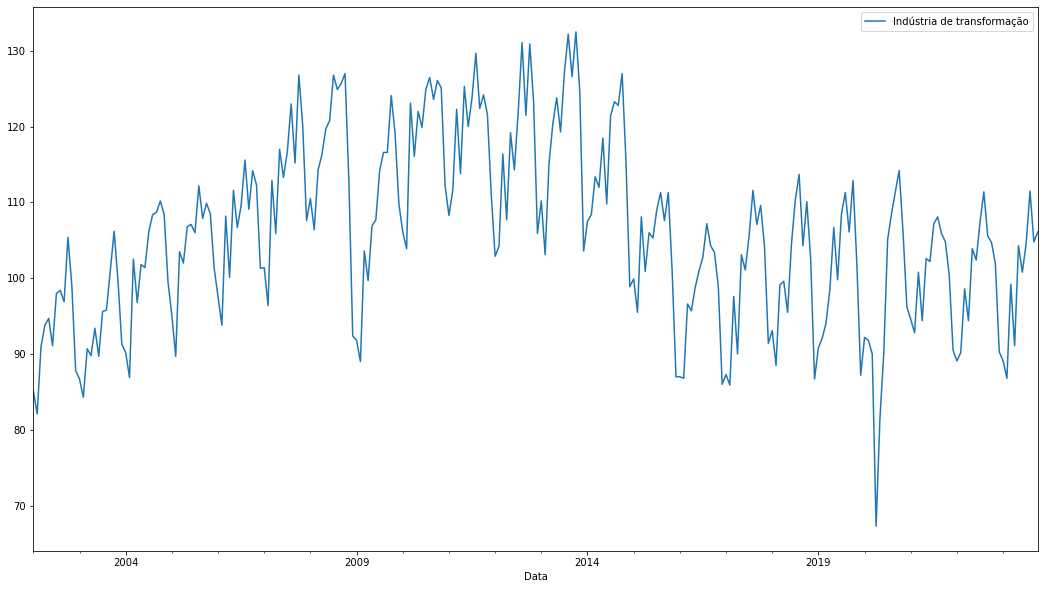

In [94]:
df_ind_transf = df.set_index('Data')[['21862 - Indicadores da produção (2022=100) - Indústria de transformação - Índice']].copy()
df_ind_transf.rename(columns={'21862 - Indicadores da produção (2022=100) - Indústria de transformação - Índice':'Indústria de transformação'}, inplace=True)
df_ind_transf.plot(figsize=(18,10))

In [95]:
df_ind_transf.head(2)

,Indústria de transformação
Data,
2002-01-01,85.1
2002-02-01,82.1


In [96]:
def detect_outliers_iqr(data):
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = (data < lower_bound) | (data > upper_bound)
    return outliers

In [97]:
industria_outliers = df_ind_transf['Indústria de transformação']  
outliers_iqr = detect_outliers_iqr(industria_outliers)
print("Outliers detectados pelo método IQR:")
print(industria_outliers[outliers_iqr])

Outliers detectados pelo método IQR:
Data
2020-04-01    67.3
Name: Indústria de transformação, dtype: float64


In [98]:
dfSMA = df.set_index('Data')[['21862 - Indicadores da produção (2022=100) - Indústria de transformação - Índice', '6-month-SMA', '12-month-SMA']].copy()
dfSMA.rename(columns={'21862 - Indicadores da produção (2022=100) - Indústria de transformação - Índice':'Indústria de transformação'}, inplace=True)
dfSMA

,Indústria de transformação,6-month-SMA,12-month-SMA
Data,,,
2002-01-01,85.1,NaN,NaN
2002-02-01,82.1,NaN,NaN
2002-03-01,91.0,NaN,NaN
2002-04-01,93.8,NaN,NaN
2002-05-01,94.7,NaN,NaN
...,...,...,...
2023-06-01,100.8,95.216667,99.383333
2023-07-01,104.6,97.800000,99.150000
2023-08-01,111.5,101.916667,99.158333


<AxesSubplot:xlabel='Data'>

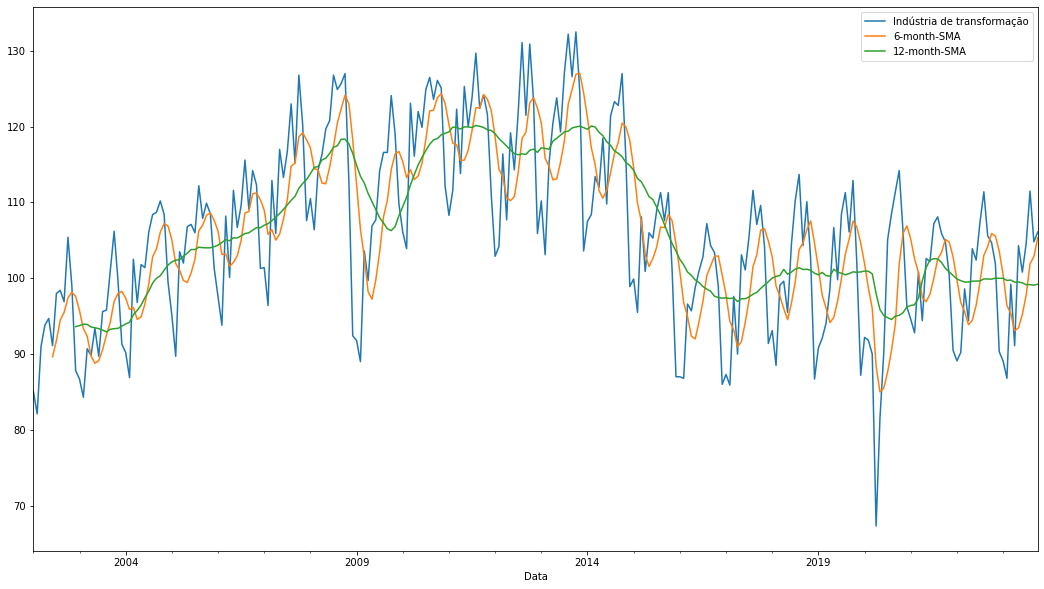

In [99]:
dfSMA.plot(figsize=(18,10))

In [100]:
#Média Móvel Exponencialmente Ponderada
df['6-month-EWMA'] = df['21862 - Indicadores da produção (2022=100) - Indústria de transformação - Índice'].ewm(span=6,adjust=False).mean()
df['12-month-EWMA'] = df['21862 - Indicadores da produção (2022=100) - Indústria de transformação - Índice'].ewm(span=12,adjust=False).mean()
df

,Data,21859 - Indicadores da produção (2022=100) - Geral - Índice,21861 - Indicadores da produção (2022=100) - Extrativa mineral - Índice,21862 - Indicadores da produção (2022=100) - Indústria de transformação - Índice,21863 - Indicadores da produção (2022=100) - Bens de capital - Índice,21864 - Indicadores da produção (2022=100) - Bens intermediários - Índice,21865 - Indicadores da produção (2022=100) - Bens de consumo - Índice,21866 - Indicadores da produção (2022=100) - Bens de consumo duráveis - Índice,21867 - Indicadores da produção (2022=100) - Semiduráveis e não duráveis - Índice,21868 - Indicadores da produção (2022=100) - Insumos da construção civil - Índice,4380 - PIB mensal - Valores correntes (R$ milhões) - R$ (milhões),11752 - Índice da taxa de câmbio real efetiva (IPCA) - Jun/1994=100 - Índice,11753 - Índice da taxa de câmbio real (IPCA) - Jun/1994=100 - Dólar americano - Índice,20360 - Índice da taxa de câmbio efetiva nominal - Jun/1994=100 - Índice,6-month-SMA,12-month-SMA,6-month-EWMA,12-month-EWMA
0,2002-01-01,84.4,72.3,85.1,58.2,88.0,86.3,79.8,87.7,NaN,112374.8,111.75,133.88,193.74,NaN,NaN,85.100000,85.100000
1,2002-02-01,81.2,68.3,82.1,56.8,85.2,82.1,77.0,83.1,NaN,111477.1,111.03,136.27,188.11,NaN,NaN,84.242857,84.638462
2,2002-03-01,90.2,78.5,91.0,64.7,94.9,90.0,91.0,89.7,NaN,118444.7,106.76,132.12,178.46,NaN,NaN,86.173469,85.617160
3,2002-04-01,92.8,77.1,93.8,68.9,96.0,94.6,101.8,92.8,NaN,120385.9,105.39,130.33,173.20,NaN,NaN,88.352478,86.876058
4,2002-05-01,93.7,79.0,94.7,66.7,99.1,93.0,92.6,92.9,NaN,123552.5,112.89,139.02,183.61,NaN,NaN,90.166056,88.079742
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257,2023-06-01,102.0,109.1,100.8,91.9,103.1,102.0,94.5,103.1,100.3,895664.2,117.47,128.82,228.62,95.216667,99.383333,98.166627,98.138794
258,2023-07-01,105.8,113.1,104.6,86.3,106.6,108.0,95.1,110.1,103.6,912717.4,118.04,127.49,225.49,97.800000,99.150000,100.004733,99.132826
259,2023-08-01,111.3,110.0,111.5,97.7,109.0,118.3,119.2,118.1,107.7,923779.8,119.48,130.49,225.06,101.916667,99.158333,103.289095,101.035468
260,2023-09-01,106.2,114.9,104.8,89.4,105.4,111.3,108.8,111.7,99.3,904464.2,118.73,131.41,223.25,102.850000,99.091667,103.720782,101.614627


In [101]:
dfEWMA = df.set_index('Data')[['21862 - Indicadores da produção (2022=100) - Indústria de transformação - Índice', '6-month-SMA', '12-month-SMA']].copy()
dfEWMA.rename(columns={'21862 - Indicadores da produção (2022=100) - Indústria de transformação - Índice':'Indústria de transformação'}, inplace=True)
dfEWMA

,Indústria de transformação,6-month-SMA,12-month-SMA
Data,,,
2002-01-01,85.1,NaN,NaN
2002-02-01,82.1,NaN,NaN
2002-03-01,91.0,NaN,NaN
2002-04-01,93.8,NaN,NaN
2002-05-01,94.7,NaN,NaN
...,...,...,...
2023-06-01,100.8,95.216667,99.383333
2023-07-01,104.6,97.800000,99.150000
2023-08-01,111.5,101.916667,99.158333


<AxesSubplot:xlabel='Data'>

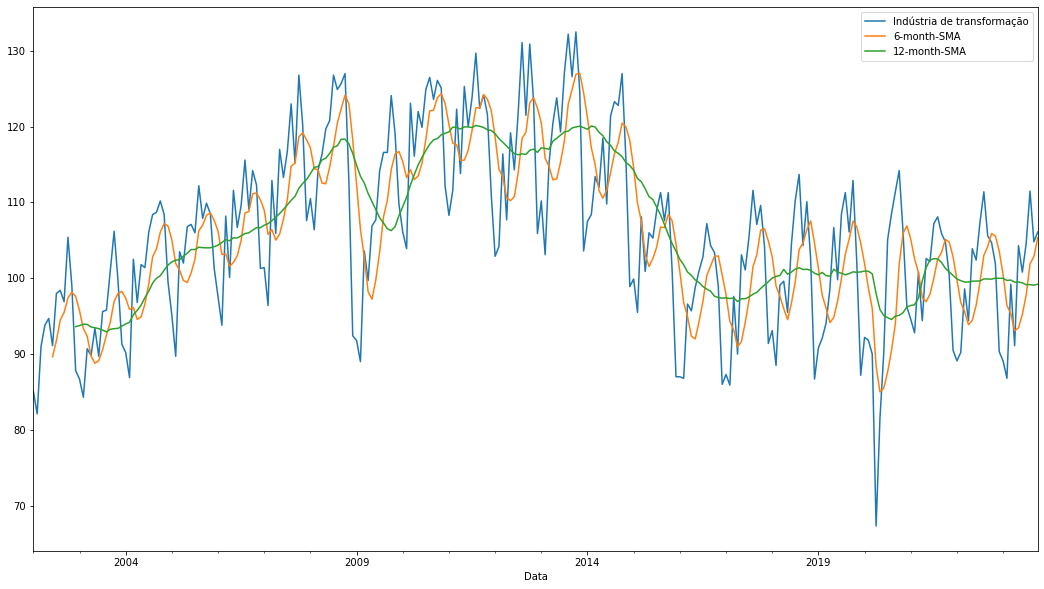

In [102]:
dfEWMA.plot(figsize=(18,10))

In [103]:
#Outliers
def detect_outliers_iqr(data):
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = (data < lower_bound) | (data > upper_bound)
    return outliers


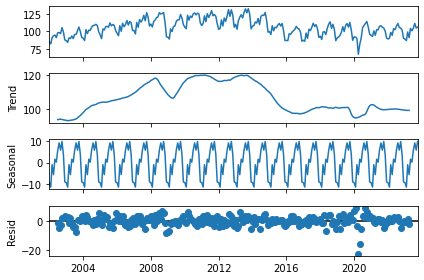

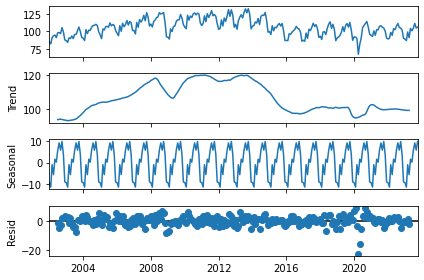

In [104]:
from statsmodels.tsa.seasonal import seasonal_decompose

seasonal_decompose(df_ind_transf,model='add').plot()



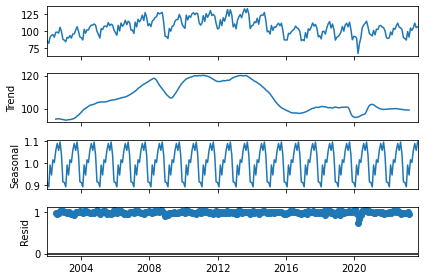

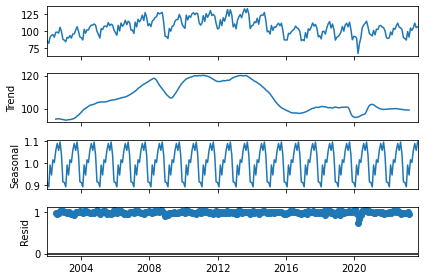

In [105]:
seasonal_decompose(df_ind_transf,model='mul').plot()

Modelo 1: ETS - Suavização Exponencial Tripla

In [106]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [107]:
len(df_ind_transf)

262

In [108]:
dados_treinados = df_ind_transf.iloc[:210] # Primeiras 80% das linhas (262 * 0.8 = 209,6)
dados_testados= df_ind_transf.iloc[210:] # Últimos 20% das linhas (262 - 210 = 52)


In [109]:
# Criando o modelo de Suavização Exponencial Tripla
fitted_model = ExponentialSmoothing(
    dados_treinados['Indústria de transformação'],
    trend='mul',
    seasonal='mul',
    seasonal_periods=12
).fit()

# Fazendo previsões
etsprevi = fitted_model.forecast(52).rename('ETS Previsão')

c:\Users\bianc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\bianc\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


In [110]:
etsprevi

2019-07-01    105.989640
2019-08-01    109.427157
2019-09-01    105.990579
2019-10-01    110.265992
2019-11-01    104.591380
2019-12-01     92.271516
2020-01-01     91.880745
2020-02-01     89.687099
2020-03-01    100.352241
2020-04-01     97.487299
2020-05-01    103.396484
2020-06-01    101.313618
2020-07-01    106.203489
2020-08-01    109.647942
2020-09-01    106.204431
2020-10-01    110.488469
2020-11-01    104.802408
2020-12-01     92.457686
2021-01-01     92.066127
2021-02-01     89.868055
2021-03-01    100.554716
2021-04-01     97.683994
2021-05-01    103.605101
2021-06-01    101.518033
2021-07-01    106.417769
2021-08-01    109.869172
2021-09-01    106.418713
2021-10-01    110.711396
2021-11-01    105.013862
2021-12-01     92.644233
2022-01-01     92.251884
2022-02-01     90.049377
2022-03-01    100.757600
2022-04-01     97.881085
2022-05-01    103.814139
2022-06-01    101.722860
2022-07-01    106.632482
2022-08-01    110.090849
2022-09-01    106.633428
2022-10-01    110.934772


In [111]:
# Ajustando o índice para corresponder aos dados testados
etsprevi.index = dados_testados.index

In [112]:
# Calcular as métricas de avaliação
mae = mean_absolute_error(dados_testados['Indústria de transformação'], etsprevi)
mse = mean_squared_error(dados_testados['Indústria de transformação'], etsprevi)
r2 = r2_score(dados_testados['Indústria de transformação'], etsprevi)
# Imprimir as métricas
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("R-squared (R²):", r2)

Mean Absolute Error (MAE): 3.5740840371766796
Mean Squared Error (MSE): 38.96326617288204
R-squared (R²): 0.5379293373068763


<AxesSubplot:xlabel='Data'>

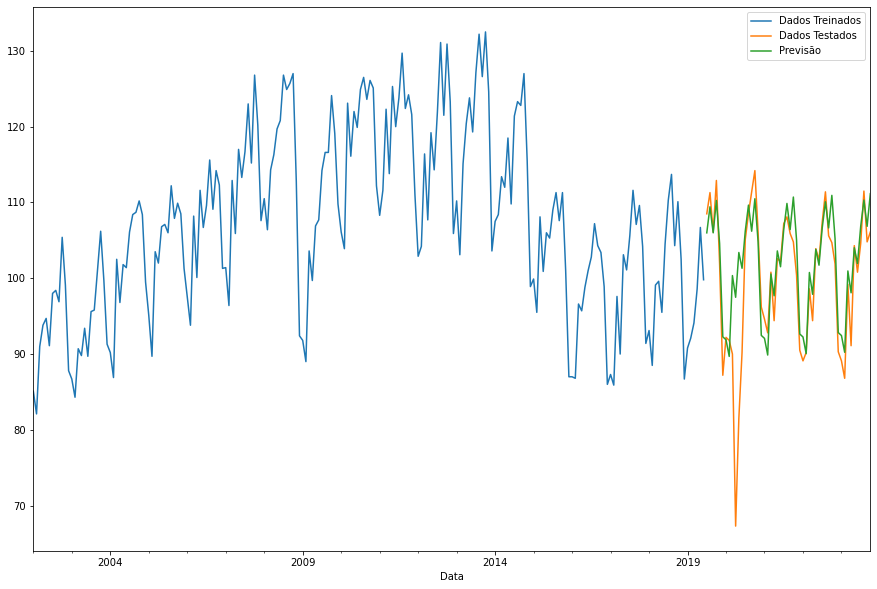

In [113]:
# Plotando os dados
dados_treinados['Indústria de transformação'].plot(legend=True, label='Dados Treinados')
dados_testados['Indústria de transformação'].plot(legend=True, label='Dados Testados', figsize=(15, 10))
etsprevi.plot(legend=True, label='Previsão')

TESTE

In [114]:
# Criar um novo DataFrame (df2) sem as colunas especificadas
df2 = df.drop(['6-month-SMA', '12-month-SMA', '6-month-EWMA', '12-month-EWMA','21868 - Indicadores da produção (2022=100) - Insumos da construção civil - Índice'], axis=1).copy()


In [115]:
#df2 = df2.reset_index()

In [140]:

import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


In [141]:
# Definir as variáveis independentes (X) e a variável dependente (y)
X = df2[['21859 - Indicadores da produção (2022=100) - Geral - Índice',
         '21861 - Indicadores da produção (2022=100) - Extrativa mineral - Índice',
         '21863 - Indicadores da produção (2022=100) - Bens de capital - Índice',
         '21864 - Indicadores da produção (2022=100) - Bens intermediários - Índice',
         '21865 - Indicadores da produção (2022=100) - Bens de consumo - Índice',
         '21866 - Indicadores da produção (2022=100) - Bens de consumo duráveis - Índice',
         '21867 - Indicadores da produção (2022=100) - Semiduráveis e não duráveis - Índice',
         '11752 - Índice da taxa de câmbio real efetiva (IPCA) - Jun/1994=100 - Índice',
         '11753 - Índice da taxa de câmbio real (IPCA) - Jun/1994=100 - Dólar americano - Índice',
         '20360 - Índice da taxa de câmbio efetiva nominal - Jun/1994=100 - Índice']]

y = df2['21862 - Indicadores da produção (2022=100) - Indústria de transformação - Índice']



In [195]:
# Definir as variáveis independentes (X) excluindo a variável alvo
X_train = df2.iloc[:210].drop(['Data', '21862 - Indicadores da produção (2022=100) - Indústria de transformação - Índice'], axis=1)
X_test = df2.iloc[210:262].drop(['Data', '21862 - Indicadores da produção (2022=100) - Indústria de transformação - Índice'], axis=1)

# Definir a variável dependente (y) para os conjuntos de treinamento e teste
y_train = df2['21862 - Indicadores da produção (2022=100) - Indústria de transformação - Índice'][:210]
y_test = df2['21862 - Indicadores da produção (2022=100) - Indústria de transformação - Índice'][210:262]


In [196]:
# Criar o modelo de regressão linear
model = LinearRegression()

In [197]:
# Treinar o modelo com os dados de treinamento
model.fit(X_train, y_train)

LinearRegression()

In [198]:

# Imprimir as métricas de desempenho
print("Erro médio quadrático:", mse)
print("Coeficiente de determinação (R²):", r2)

Erro médio quadrático: 0.04912245815900335
Coeficiente de determinação (R²): 0.999417450100463


In [199]:
# Calcular métricas de desempenho
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [200]:
# Fazer previsões usando os dados de teste
y_pred = model.predict(X_test)

In [201]:
y_pred

array([108.55488648, 111.36709927, 106.14278361, 112.98160407,
       102.078026  ,  87.33853459,  92.18890445,  91.71395343,
        89.88141585,  67.2665228 ,  81.34138588,  90.12161084,
       105.00478721, 108.36649742, 111.25671028, 113.97030935,
       105.93003203,  96.17901738,  94.66800454,  92.63859032,
       100.38548722,  94.16222402, 102.61629422, 102.14667729,
       107.19741152, 108.12858375, 105.99650797, 104.77195513,
       100.34021468,  90.48250915,  89.13551978,  89.98854875,
        98.29788485,  94.26966077, 103.52835564, 102.01326329,
       107.06314238, 111.05713455, 105.35957227, 104.89326857,
       101.47125466,  90.55791696,  89.01561968,  86.74908279,
        98.98235093,  90.8106969 , 103.90346085, 100.92440995,
       104.43483955, 110.87605206, 104.75790953, 105.91464309])

In [202]:
# Criar uma série de datas correspondentes aos meses para os dados de teste
dates_test = df2.iloc[210:262]['Data']

In [203]:
# Criar um DataFrame com as datas e as previsões
predictions_df = pd.DataFrame({'Data': dates_test, 'Previsões': y_pred})

In [209]:
predictions_df

,Data,Previsões
210,2019-07-01,108.554886
211,2019-08-01,111.367099
212,2019-09-01,106.142784
213,2019-10-01,112.981604
214,2019-11-01,102.078026
215,2019-12-01,87.338535
216,2020-01-01,92.188904
217,2020-02-01,91.713953
218,2020-03-01,89.881416
219,2020-04-01,67.266523


In [211]:
# Extrair o histórico correspondente aos dados de teste
historical_data = df2.iloc[210:262]

In [212]:
# Configurar o índice do DataFrame como as datas
predictions_df.set_index('Data', inplace=True)

In [217]:
# Converter a coluna de datas para uma lista de datas
datas = historical_data['Data'].tolist()

In [242]:
import pandas as pd

# Criar uma lista de datas para as previsões
dates = pd.date_range(start='2023-01-01', periods=len(predictions_df), freq='MS')

# Adicionar as datas ao DataFrame predictions_df
predictions_df['Data'] = dates

# Definir a coluna 'Data' como índice
predictions_df.set_index('Data', inplace=True)


In [259]:
# Criar DataFrame apenas com as colunas 'Data' e '21862 - Indicadores da produção (2022=100) - Indústria de transformação - Índice'
df_transformacao = df2[['Data', '21862 - Indicadores da produção (2022=100) - Indústria de transformação - Índice']].copy()


# Definir a coluna 'Data' como índice do DataFrame df_transformacao
df_transformacao.set_index('Data', inplace=True)
# Exibir as primeiras linhas do DataFrame para verificação
df_transformacao.head()



,21862 - Indicadores da produção (2022=100) - Indústria de transformação - Índice
Data,
2002-01-01,85.1
2002-02-01,82.1
2002-03-01,91.0
2002-04-01,93.8
2002-05-01,94.7


In [260]:
import matplotlib.pyplot as plt

# Remover linhas com valores NaN
df_ind_clean = df_ind.dropna(subset=['Previsões'])



In [286]:
# Converter o índice de predictions_df para o tipo datetime
predictions_df.index = pd.to_datetime(predictions_df.index)

# Selecionar as previsões até junho de 2024
predictions_until_june_2024 = predictions_df.loc[predictions_df.index <= '2024-06-01']

In [287]:
predictions_until_june_2024

,Previsões
Data,
2023-01-01,108.554886
2023-02-01,111.367099
2023-03-01,106.142784
2023-04-01,112.981604
2023-05-01,102.078026
2023-06-01,87.338535
2023-07-01,92.188904
2023-08-01,91.713953
2023-09-01,89.881416


In [278]:
df_transformacao

,21862 - Indicadores da produção (2022=100) - Indústria de transformação - Índice
Data,
2002-01-01,85.1
2002-02-01,82.1
2002-03-01,91.0
2002-04-01,93.8
2002-05-01,94.7
...,...
2023-06-01,100.8
2023-07-01,104.6
2023-08-01,111.5


In [303]:
df_combined = pd.merge(df_transformacao.reset_index(), predictions_until_june_2024.reset_index(), on = 'Data', how = 'left').reset_index(drop = True).set_index('Data')
df_combined

,21862 - Indicadores da produção (2022=100) - Indústria de transformação - Índice,Previsões
Data,,
2002-01-01,85.1,NaN
2002-02-01,82.1,NaN
2002-03-01,91.0,NaN
2002-04-01,93.8,NaN
2002-05-01,94.7,NaN
...,...,...
2023-06-01,100.8,87.338535
2023-07-01,104.6,92.188904
2023-08-01,111.5,91.713953


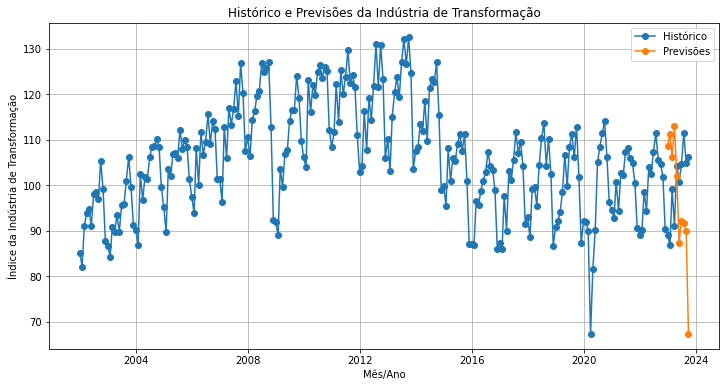

In [305]:
# Plotar o histórico e as previsões até junho de 2024
plt.figure(figsize=(12, 6))
plt.plot(df_combined['21862 - Indicadores da produção (2022=100) - Indústria de transformação - Índice'], marker='o', label='Histórico')
plt.plot(df_combined['Previsões'], marker='o', label='Previsões')
plt.xlabel('Mês/Ano')
plt.ylabel('Índice da Indústria de Transformação')
plt.title('Histórico e Previsões da Indústria de Transformação')
plt.legend()
plt.grid(True)
plt.show()


In [296]:
# Plotar o histórico e as previsões até junho de 2024
plt.figure(figsize=(12, 6))
plt.plot(df_transformacao['Data'], df_transformacao['21862 - Indicadores da produção (2022=100) - Indústria de transformação - Índice'], marker='o', label='Histórico')
plt.plot(predictions_until_june_2024.index, predictions_until_june_2024['Previsões'], marker='o', label='Previsões')
plt.xlabel('Mês/Ano')
plt.ylabel('Índice da Indústria de Transformação')
plt.title('Histórico e Previsões da Indústria de Transformação')
plt.legend()
plt.grid(True)
plt.show()


KeyError: 'Data'

<Figure size 864x432 with 0 Axes>

ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

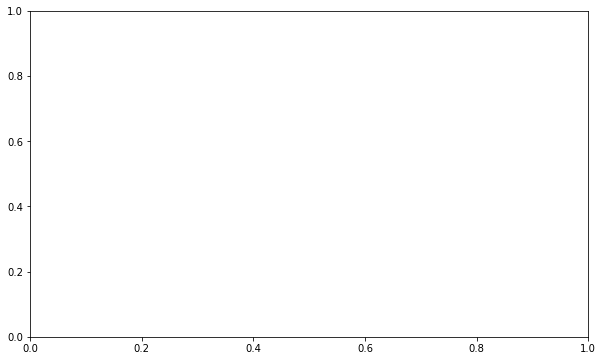

In [213]:
# Plotar o histórico e as previsões
plt.figure(figsize=(10, 6))
plt.plot(historical_data['Data'], historical_data['21862 - Indicadores da produção (2022=100) - Indústria de transformação - Índice'], marker='o', label='Histórico')
plt.plot(predictions_df.index, predictions_df['Previsões'], marker='o', label='Previsões')
plt.xlabel('Mês/Ano')
plt.ylabel('Índice da Produção')
plt.title('Histórico vs. Previsões')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [174]:
# Criar o objeto GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

In [175]:
# Executar o Grid Search
grid_search.fit(X_train, y_train)

ValueError: Found input variables with inconsistent numbers of samples: [209, 210]

In [158]:
# Melhores parâmetros encontrados
best_params = grid_search.best_params_
print("Melhores parâmetros encontrados:", best_params)

Melhores parâmetros encontrados: {'fit_intercept': False}


In [159]:
# Melhor modelo encontrado
best_model = grid_search.best_estimator_

In [160]:
# Fazer previsões usando o melhor modelo
y_pred = best_model.predict(X_test)

In [161]:

# Calcular métricas de desempenho usando o melhor modelo
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [162]:
# Imprimir as métricas de desempenho
print("Erro médio quadrático:", mse)
print("Coeficiente de determinação (R²):", r2)

Erro médio quadrático: 0.02140081409378522
Coeficiente de determinação (R²): 0.99984510577174


ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

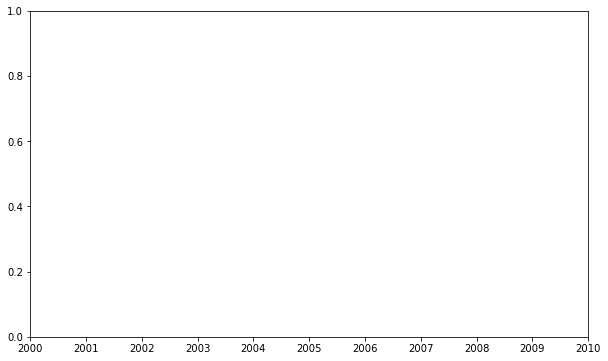

In [170]:
import matplotlib.pyplot as plt

# Plotar os valores reais vs. previsões por mês/ano
plt.figure(figsize=(10, 6))
plt.plot_date(df_results['Data'], df_results['Valores Reais'], fmt='o-', label='Valores Reais')
plt.plot_date(df_results['Data'], df_results['Previsões'], fmt='o-', label='Previsões')
plt.xlabel('Mês/Ano')
plt.ylabel('Valor')
plt.title('Valores Reais vs. Previsões por Mês/Ano')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



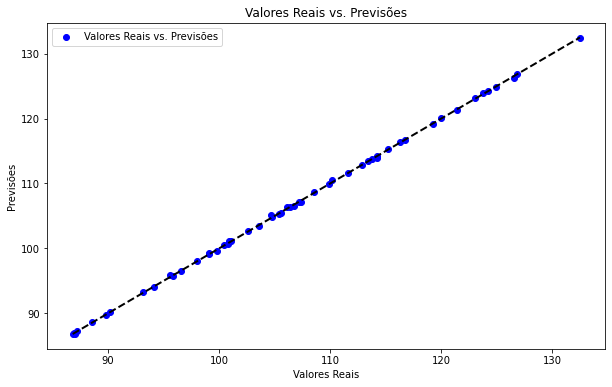

In [163]:
# Plotar os valores reais vs. previsões
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', label='Valores Reais vs. Previsões')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Valores Reais')
plt.ylabel('Previsões')
plt.title('Valores Reais vs. Previsões')
plt.legend()
plt.show()

In [121]:
# Fazer previsões usando os dados de teste
y_pred = model.predict(X_test)

In [122]:
# Calcular métricas de desempenho
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [123]:

# Imprimir as métricas de desempenho
print("Erro médio quadrático:", mse)
print("Coeficiente de determinação (R²):", r2)

Erro médio quadrático: 0.021400627782936808
Coeficiente de determinação (R²): 0.9998451071202156


In [124]:
# Criar um novo DataFrame com a coluna 'Data'
df2 = df[['Data', '21862 - Indicadores da produção (2022=100) - Indústria de transformação - Índice']].copy()


In [125]:
# Definir a coluna 'Data' como índice
df2.set_index('Data', inplace=True)

In [126]:
# Converter o índice e a série em arrays numpy
x = np.array(df2.index)
y = np.array(df2['21862 - Indicadores da produção (2022=100) - Indústria de transformação - Índice'])


In [127]:
# Converter o índice do DataFrame em uma lista de datas
dates = df2.index.tolist()


In [131]:
# Verificar o tamanho do array y_pred
print("Tamanho de y_pred:", len(y_pred))
# Verificar o número de observações no DataFrame original
print("Número de observações no DataFrame original:", len(df2))

Tamanho de y_pred: 53
Número de observações no DataFrame original: 262


In [133]:
print("Tamanho de y_pred:", len(y_pred))
print("Número de observações no DataFrame original:", len(df2))


Tamanho de y_pred: 53
Número de observações no DataFrame original: 262


In [129]:
# Criar um array com o histórico e as previsões
historico_previsao = np.column_stack((df2['21862 - Indicadores da produção (2022=100) - Indústria de transformação - Índice'], y_pred))


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 262 and the array at index 1 has size 53

ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

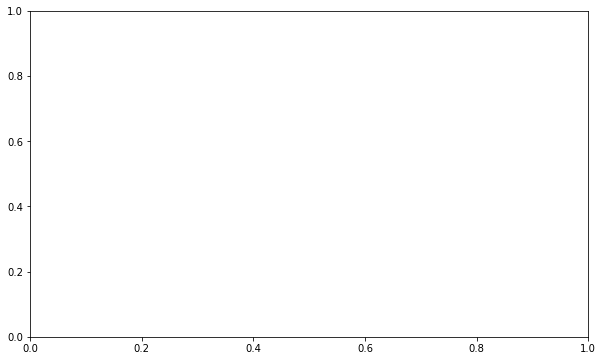

In [ ]:
# Plotar o gráfico comparando a história com a previsão
plt.figure(figsize=(10, 6))
plt.plot(dates, df2.loc[:, '21862 - Indicadores da produção (2022=100) - Indústria de transformação - Índice'], color='blue', label='Histórico')
plt.plot(dates, y_pred, color='red', label='Previsão')
plt.xlabel('Data')
plt.ylabel('Índice')
plt.title('Comparação entre Histórico e Previsão da Indústria de Transformação')
plt.legend()
plt.show()

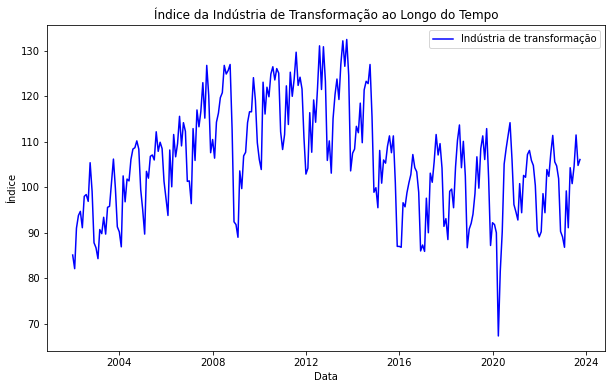

In [ ]:
# Plotar o gráfico
plt.figure(figsize=(10, 6))
plt.plot(x, y, color='blue', label='Indústria de transformação')
plt.xlabel('Data')
plt.ylabel('Índice')
plt.title('Índice da Indústria de Transformação ao Longo do Tempo')
plt.legend()
plt.show()

In [ ]:
df2

,21859 - Indicadores da produção (2022=100) - Geral - Índice,21861 - Indicadores da produção (2022=100) - Extrativa mineral - Índice,21862 - Indicadores da produção (2022=100) - Indústria de transformação - Índice,21863 - Indicadores da produção (2022=100) - Bens de capital - Índice,21864 - Indicadores da produção (2022=100) - Bens intermediários - Índice,21865 - Indicadores da produção (2022=100) - Bens de consumo - Índice,21866 - Indicadores da produção (2022=100) - Bens de consumo duráveis - Índice,21867 - Indicadores da produção (2022=100) - Semiduráveis e não duráveis - Índice,4380 - PIB mensal - Valores correntes (R$ milhões) - R$ (milhões),11752 - Índice da taxa de câmbio real efetiva (IPCA) - Jun/1994=100 - Índice,11753 - Índice da taxa de câmbio real (IPCA) - Jun/1994=100 - Dólar americano - Índice,20360 - Índice da taxa de câmbio efetiva nominal - Jun/1994=100 - Índice
Data,,,,,,,,,,,,
2002-01-01,84.4,72.3,85.1,58.2,88.0,86.3,79.8,87.7,112374.8,111.75,133.88,193.74
2002-02-01,81.2,68.3,82.1,56.8,85.2,82.1,77.0,83.1,111477.1,111.03,136.27,188.11
2002-03-01,90.2,78.5,91.0,64.7,94.9,90.0,91.0,89.7,118444.7,106.76,132.12,178.46
2002-04-01,92.8,77.1,93.8,68.9,96.0,94.6,101.8,92.8,120385.9,105.39,130.33,173.20
2002-05-01,93.7,79.0,94.7,66.7,99.1,93.0,92.6,92.9,123552.5,112.89,139.02,183.61
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-01,102.0,109.1,100.8,91.9,103.1,102.0,94.5,103.1,895664.2,117.47,128.82,228.62
2023-07-01,105.8,113.1,104.6,86.3,106.6,108.0,95.1,110.1,912717.4,118.04,127.49,225.49
2023-08-01,111.3,110.0,111.5,97.7,109.0,118.3,119.2,118.1,923779.8,119.48,130.49,225.06


In [ ]:
# Dividir os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)


NameError: name 'x' is not defined

In [ ]:
# Instanciar o modelo de regressão linear
model = LinearRegression()

In [ ]:
# Treinar o modelo com os dados de treinamento limpos
model.fit(x, y)


LinearRegression()

In [ ]:
# Fazer previsões com os dados de treinamento
y_pred = model.predict(x)

In [ ]:
# Visualizar os coeficientes do modelo
coefficients = pd.DataFrame(model.coef_, x.columns, columns=['Coeficiente'])
print("Coeficientes do modelo:")
print(coefficients)

Coeficientes do modelo:
                                                     Coeficiente
21859 - Indicadores da produção (2022=100) - Ge...  5.258820e-01
21861 - Indicadores da produção (2022=100) - Ex... -1.043323e-01
21863 - Indicadores da produção (2022=100) - Be...  6.238241e-02
21864 - Indicadores da produção (2022=100) - Be...  3.321646e-01
21865 - Indicadores da produção (2022=100) - Be...  2.307061e-01
21866 - Indicadores da produção (2022=100) - Be... -1.100660e-02
21867 - Indicadores da produção (2022=100) - Se... -3.570774e-02
4380 - PIB mensal - Valores correntes (R$ milhõ...  3.730498e-07
11752 - Índice da taxa de câmbio real efetiva (... -3.143557e-03
11753 - Índice da taxa de câmbio real (IPCA) - ... -6.637530e-03
20360 - Índice da taxa de câmbio efetiva nomina...  3.232969e-03


In [ ]:
# Selecionar coeficientes acima de 50%
coefficients_above_threshold = coefficients[abs(coefficients['Coeficiente']) > 0.5]

# Imprimir os coeficientes selecionados
print("Coeficientes do modelo acima de 50%:")
print(coefficients_above_threshold)


Coeficientes do modelo acima de 50%:
                                                    Coeficiente
21859 - Indicadores da produção (2022=100) - Ge...     0.525882


In [ ]:
# Exibir as previsões
print(y_pred)

[ 85.18757329  82.09865553  90.92740597  93.89974072  94.74941196
  91.00633319  98.0396965   98.30269875  96.80844038 105.2686796
  99.05038927  87.53204156  86.30037994  84.06423688  90.43442088
  89.72035797  93.33232209  89.82989048  95.80091931  95.75165731
 101.19062467 106.50830705  99.95725315  91.22766584  90.19772637
  86.9026142  102.83655079  96.98620843 102.04916955 101.69297752
 106.42070996 108.65234472 109.04035604 110.49620482 108.74374989
  99.55032324  95.07314478  89.85233069 103.72543628 102.03270388
 106.82853845 107.2170839  106.05827205 112.40194859 108.00179296
 109.92020933 108.67640426 101.10581432  97.23125129  93.75328736
 108.20008208  99.92896807 111.55696258 106.7614757  109.61604117
 115.68220549 109.14773627 114.17862121 112.24462844 100.87909362
 101.07586917  96.26265223 112.84917803 105.80015617 117.08399814
 113.36311269 116.64166169 123.16690407 115.2874697  127.09610437
 120.2911335  107.10230727 110.32398626 106.36450367 114.23634836
 116.460093

In [ ]:
y_test_all = y_test_np[210:]
y_pred_all = y_pred_2[:210]

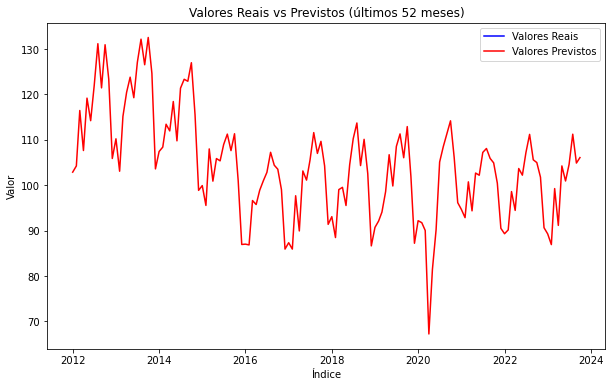

In [ ]:
# Plotar os valores reais (y_test) versus os valores previstos (y_pred_2)
plt.figure(figsize=(10, 6))
plt.plot(y_test_np_last_52, color='blue', label='Valores Reais')
plt.plot(y_pred_2_last_52, color='red', label='Valores Previstos')
plt.xlabel('Índice')
plt.ylabel('Valor')
plt.title('Valores Reais vs Previstos (últimos 52 meses)')
plt.legend()
plt.show()

In [ ]:
X = df[['21859 - Indicadores da produção (2022=100) - Geral - Índice']]
y = df['21862 - Indicadores da produção (2022=100) - Indústria de transformação - Índice']

In [ ]:
# Dividir os dados em conjunto de treinamento e teste
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Inicializar o modelo de regressão linear
model = LinearRegression()

In [ ]:
# Treinar o modelo com os dados de treinamento
model.fit(X_train, y_train)


LinearRegression()

In [ ]:
# Fazer previsões nos dados de teste
y_pred = model.predict(X_test)

In [ ]:
y_pred

array([105.37689906,  88.98682414, 100.11970522,  88.16216629,
       116.4066979 , 118.67450701, 108.26320156, 105.99539245,
       103.62450111, 123.93170085,  88.78065968, 113.41731317,
       107.54162593,  93.83168906,  95.37792254,  86.71901504,
       124.96252317,  96.51182709,  99.60429406, 122.59163183,
       125.3748521 , 113.41731317,  94.55326468, 113.10806647,
       113.62347763, 121.97313844, 126.81800335, 114.65429995,
       113.93272433,  88.47141298, 104.75840566,  89.29607084,
        99.91354075, 111.14950406, 108.77861272, 102.79984325,
       105.89231022, 100.22278745, 105.78922799,  97.33648495,
       105.68614575, 109.08785942, 124.13786531, 115.68512227,
        85.48202825, 103.21217218, 102.69676102,  94.24401798,
       102.90292549, 131.76595049, 106.92313254,  97.02723825,
       120.01457602])

In [ ]:
# Avaliar o modelo
from sklearn.metrics import mean_squared_error, r2_score
print("Erro médio quadrático:", mean_squared_error(y_test, y_pred))
print("Coeficiente de determinação (R²):", r2_score(y_test, y_pred))

Erro médio quadrático: 1.0166760283421632
Coeficiente de determinação (R²): 0.9926415299852417


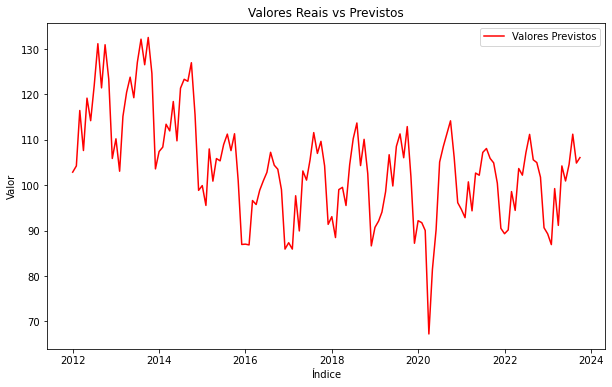

In [ ]:
# Plotar os valores reais (y_test) versus os valores previstos (y_pred_2)
plt.figure(figsize=(10, 6))
#plt.plot(y_test_np_last_52, color='blue', label='Valores Reais')
plt.plot(y_pred_2_last_52, color='red', label='Valores Previstos')
plt.xlabel('Índice')
plt.ylabel('Valor')
plt.title('Valores Reais vs Previstos')
plt.legend()
plt.show()


In [ ]:
X = [
    df,
    '21859 - Indicadores da produção (2022=100) - Geral - Índice',
    '21861 - Indicadores da produção (2022=100) - Extrativa mineral - Índice',
    '21863 - Indicadores da produção (2022=100) - Bens de capital - Índice',
    '21864 - Indicadores da produção (2022=100) - Bens intermediários - Índice',
    '21865 - Indicadores da produção (2022=100) - Bens de consumo - Índice',
    '21866 - Indicadores da produção (2022=100) - Bens de consumo duráveis - Índice',
    '21867 - Indicadores da produção (2022=100) - Semiduráveis e não duráveis - Índice',
    '21868 - Indicadores da produção (2022=100) - Insumos da construção civil - Índice',
    '4380 - PIB mensal - Valores correntes (R$ milhões) - R$ (milhões)',
    '11752 - Índice da taxa de câmbio real efetiva (IPCA) - Jun/1994=100 - Índice',
    '11753 - Índice da taxa de câmbio real (IPCA) - Jun/1994=100 - Dólar americano - Índice',
    '20360 - Índice da taxa de câmbio efetiva nominal - Jun/1994=100 - Índice',
    'Data'
]

y = [
    df,
    '21862 - Indicadores da produção (2022=100) - Indústria de transformação - Índice'
]

In [ ]:
X_train = X.iloc[:210] # Primeiras 80% das linhas (262 * 0.8 = 209,6)
X_test = X.iloc[210:] # Últimos 20% das linhas (262 - 210 = 52)
y_train = y.iloc[:210] # Primeiras 80% das linhas (262 * 0.8 = 209,6)
y_test = y.iloc[210:] # Últimos 20% das linhas (262 - 210 = 52)


AttributeError: 'list' object has no attribute 'iloc'

Regressão Linear

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error


In [ ]:
# Preencher os valores ausentes em X_test com a média dos valores em X_train
imputer = SimpleImputer(strategy='mean')
X_test_imputed = imputer.fit_transform(X_test)

In [ ]:
# Calcular as previsões do modelo Lasso com os dados de teste imputados
y_pred_lasso = lasso_model.predict(X_test_imputed)

# Aplicar o imputer aos dados de treinamento e teste
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)


In [ ]:
# Modelo de Regressão Lasso
lasso_model = Lasso(alpha=1.0)  # Você pode ajustar o valor de alpha conforme necessário
lasso_model.fit(X_train_imputed, y_train)
y_pred_lasso = lasso_model.predict(X_test_imputed)
lasso_mse = mean_squared_error(y_test, y_pred_lasso)
print("Erro quadrático médio (Lasso):", lasso_mse)

Erro quadrático médio (Lasso): 0.007252432651670707


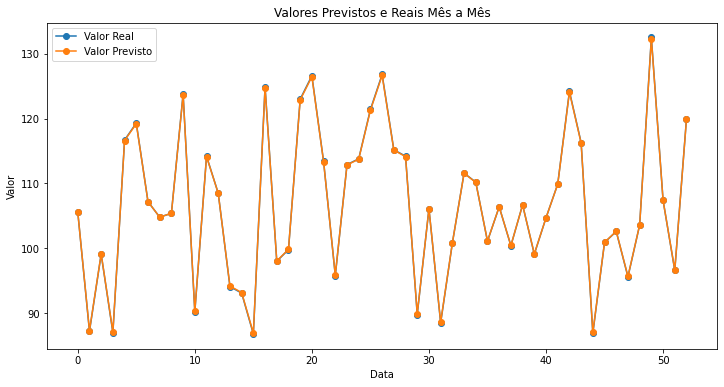

In [ ]:
# Converter índice 'Data' para array numpy
dates = df_dates.index.values

# Converter 'Valor Real' e 'Valor Previsto' para arrays numpy
real_values = df_dates['Valor Real'].values
predicted_values = df_dates['Valor Previsto'].values

# Plot dos valores previstos e reais mês a mês
plt.figure(figsize=(12, 6))
plt.plot(dates, real_values, marker='o', linestyle='-', label='Valor Real')
plt.plot(dates, predicted_values, marker='o', linestyle='-', label='Valor Previsto')
plt.xlabel('Data')
plt.ylabel('Valor')
plt.title('Valores Previstos e Reais Mês a Mês')
plt.legend()
plt.show()


In [ ]:
X_train = X.iloc[:210] # Primeiras 80% das linhas (262 * 0.8 = 209,6)
X_test = X.iloc[210:] # Últimos 20% das linhas (262 - 210 = 52)
y_train = y.iloc[:210] # Primeiras 80% das linhas (262 * 0.8 = 209,6)
y_test = y.iloc[210:] # Últimos 20% das linhas (262 - 210 = 52)

In [ ]:
# Passo 1: Dividir os dados em conjunto de treinamento e conjunto de teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
model = LinearRegression()


In [ ]:
from sklearn.impute import SimpleImputer

In [ ]:
# Inicializar o imputador
imputer = SimpleImputer(strategy='mean')

In [ ]:
# Ajustar o imputador aos dados de treinamento
imputer.fit(X_train)


SimpleImputer()

In [ ]:
# Imputar os dados de treinamento
X_train_imputed = imputer.transform(X_train)

In [ ]:
# Imputar os dados de teste
X_test_imputed = imputer.transform(X_test)

In [ ]:
# Aplicar a imputação aos dados de treinamento
X_train_imputed = imputer.fit_transform(X_train)
y_train_imputed = imputer.fit_transform(y_train.values.reshape(-1, 1))

In [ ]:
# Treinar o modelo com os dados imputados
model.fit(X_train_imputed, y_train_imputed)

LinearRegression()

In [ ]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


X_train shape: (209, 5)
X_test shape: (53, 5)
y_train shape: (209,)
y_test shape: (53,)


In [ ]:
# Passo 2: Instanciar o modelo de regressão linear
model = LinearRegression()


In [ ]:
# Preencher NaNs com a média
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)


In [ ]:
# Treinar o modelo de regressão linear
model.fit(X_train_imputed, y_train)

LinearRegression()

In [ ]:
# Avaliar o desempenho do modelo
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R²):", r2)

NameError: name 'y_pred' is not defined

NameError: name 'y_test' is not defined

Modelo 2: Modelo auto-regressivo

In [ ]:
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import arma_order_select_ic

In [ ]:
data = df_ind_transf['Indústria de transformação']

In [ ]:
max_lags = 10 
res = arma_order_select_ic(data, max_ar=max_lags, ic='aic', trend='c')
p = res.aic_min_order[0] 

c:\Users\bianc\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\bianc\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\bianc\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\bianc\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\bianc\anaconda3\lib\site-packages\statsmodels\base\model

In [ ]:
# Dividindo os dados em conjuntos de treinamento e teste
train_data = data[:210]
test_data = data[210:]

In [ ]:
model = AutoReg(train_data, lags=p)
model_fit = model.fit()

c:\Users\bianc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [ ]:
predictions = model_fit.predict(start=len(train_data), end=len(train_data)+len(test_data)-1)

c:\Users\bianc\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:307: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


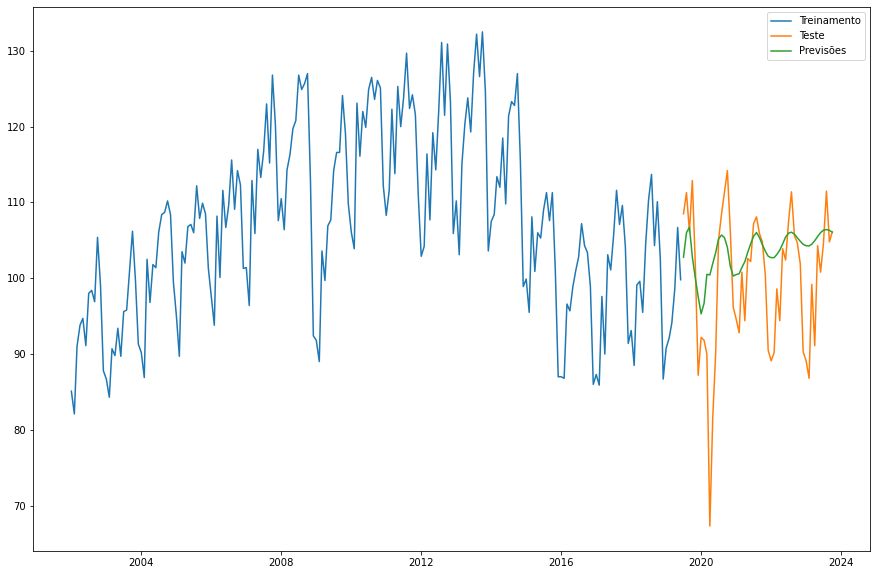

In [ ]:
plt.figure(figsize=(15, 10))
plt.plot(train_data, label='Treinamento')
plt.plot(test_data, label='Teste')
plt.plot(predictions, label='Previsões')
plt.legend()
plt.show()

In [ ]:
predictions

2019-07-01    102.781750
2019-08-01    106.010231
2019-09-01    106.737900
2019-10-01    102.819761
2019-11-01    100.058614
2019-12-01     97.563178
2020-01-01     95.299405
2020-02-01     96.712658
2020-03-01    100.516659
2020-04-01    100.430205
2020-05-01    101.928041
2020-06-01    103.393242
2020-07-01    105.194969
2020-08-01    105.702496
2020-09-01    105.344341
2020-10-01    104.078754
2020-11-01    101.537684
2020-12-01    100.286487
2021-01-01    100.484985
2021-02-01    100.597322
2021-03-01    101.410420
2021-04-01    102.177887
2021-05-01    103.405904
2021-06-01    104.530276
2021-07-01    105.525129
2021-08-01    106.031047
2021-09-01    105.364922
2021-10-01    104.432394
2021-11-01    103.571991
2021-12-01    102.900164
2022-01-01    102.711676
2022-02-01    102.723453
2022-03-01    103.125990
2022-04-01    103.702413
2022-05-01    104.536336
2022-06-01    105.441484
2022-07-01    105.940956
2022-08-01    106.078584
2022-09-01    105.813152
2022-10-01    105.336317


In [ ]:
# Calcular as previsões
predictions = model_fit.predict(start=len(train_data), end=len(train_data)+len(test_data)-1)

# Calcular o MAE
mae = mean_absolute_error(test_data, predictions)

# Calcular o MSE
mse = mean_squared_error(test_data, predictions)

# Calcular o R-squared (R²)
r2 = r2_score(test_data, predictions)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("R-squared (R²):", r2)

Mean Absolute Error (MAE): 6.295203930530026
Mean Squared Error (MSE): 79.61245096663582
R-squared (R²): 0.05586513683033467


c:\Users\bianc\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:307: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


ARIMA - TESTE

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
model = ARIMA(dados_treinados['Indústria de transformação'], order=(5,1,0))  
model_fit = model.fit()
predictions = model_fit.forecast(steps=len(dados_testados))

c:\Users\bianc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\bianc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\bianc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Regressão Linear

In [ ]:
import statsmodels.api as sm

In [ ]:
df_clean = df.dropna() # Remover linhas com valores ausentes

NameError: name 'df' is not defined

In [ ]:
# Verificar se há valores infinitos nas variáveis independentes
inf_mask = np.isinf(df_clean[['21859 - Indicadores da produção (2022=100) - Geral - Índice', '21861 - Indicadores da produção (2022=100) - Extrativa mineral - Índice', '21863 - Indicadores da produção (2022=100) - Bens de capital - Índice','21864 - Indicadores da produção (2022=100) - Bens intermediários - Índice','21865 - Indicadores da produção (2022=100) - Bens de consumo - Índice','21866 - Indicadores da produção (2022=100) - Bens de consumo duráveis - Índice','21867 - Indicadores da produção (2022=100) - Semiduráveis e não duráveis - Índice','21868 - Indicadores da produção (2022=100) - Insumos da construção civil - Índice','4380 - PIB mensal - Valores correntes (R$ milhões) - R$ (milhões)','11752 - Índice da taxa de câmbio real efetiva (IPCA) - Jun/1994=100 - Índice','11753 - Índice da taxa de câmbio real (IPCA) - Jun/1994=100 - Dólar americano - Índice','20360 - Índice da taxa de câmbio efetiva nominal - Jun/1994=100 - Índice']]).any(axis=1)
df_clean = df_clean[~inf_mask] 

In [ ]:
# Variáveis independentes
X = df_clean[['21859 - Indicadores da produção (2022=100) - Geral - Índice', '21861 - Indicadores da produção (2022=100) - Extrativa mineral - Índice', '21863 - Indicadores da produção (2022=100) - Bens de capital - Índice','21864 - Indicadores da produção (2022=100) - Bens intermediários - Índice','21865 - Indicadores da produção (2022=100) - Bens de consumo - Índice','21866 - Indicadores da produção (2022=100) - Bens de consumo duráveis - Índice','21867 - Indicadores da produção (2022=100) - Semiduráveis e não duráveis - Índice','21868 - Indicadores da produção (2022=100) - Insumos da construção civil - Índice','4380 - PIB mensal - Valores correntes (R$ milhões) - R$ (milhões)','11752 - Índice da taxa de câmbio real efetiva (IPCA) - Jun/1994=100 - Índice','11753 - Índice da taxa de câmbio real (IPCA) - Jun/1994=100 - Dólar americano - Índice','20360 - Índice da taxa de câmbio efetiva nominal - Jun/1994=100 - Índice']]
X = sm.add_constant(X)

In [ ]:
# Adicionando a constante
X = sm.add_constant(X)

In [ ]:
# Selecionando apenas as variáveis relevantes do DataFrame
df_relevant = df[relevant_variables]

In [ ]:
# Adicionando uma constante ao conjunto de variáveis independentes (X) para estimar o termo de interceptação
X = sm.add_constant(X)

In [ ]:
new_df = sm.add_constant(df_relevant)

In [ ]:
from sklearn.model_selection import train_test_split


In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score 

Modelo: SARIMAX

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
from pmdarima import auto_arima                              # for determining ARIMA orders


In [ ]:
import warnings
warnings.filterwarnings("ignore")
